In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import root_mean_squared_error

#hyperparameters

#N_EPOCHS was increased to improve model performance
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#definitions of models

#standard RNN, not so great with long term memory
class StockRNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

#LSTM, better with long term memory
class StockLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

#GRU, less parameters
class StockGRU(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])


#create sequences aligns all the data
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # Predict Close/Last
    return np.array(X), np.array(y)

In [3]:
#reading and splitting of data
df = pd.read_csv("NASDAQ-100 (NDX) Historical Data 5Y.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date")
#df_filtered = df[(df["Date"].dt.year >= 2020) & (df["Date"].dt.year <= 2024)].reset_index(drop=True)

features = ["Close/Last", "Open", "High", "Low"]

In [4]:
#preparation of data

#values normalized between 0 and 1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

X, y = create_sequences(scaled, SEQ_LEN)
dates = df["Date"][SEQ_LEN:].reset_index(drop=True)

#define test and train sets then reshape data
train_idx = dates.dt.year <= 2023
test_idx = dates.dt.year == 2024

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [5]:
#training

#more hyperparameters
hidden_sizes = [32, 64, 128, 256]
learning_rates = [0.0005, 0.001, 0.005, 0.01]
num_layers_list = [1, 2, 3]

grid = list(product(hidden_sizes, learning_rates, num_layers_list))

results = {}

for name, ModelClass in [("GRU", StockGRU), ("LSTM", StockLSTM), ("RNN", StockRNN)]:
    results[name] = {}
    
    for HIDDEN_SIZE, LEARNING_RATE, NUM_LAYERS in grid:

        #setup the model and create label for plot
        label = f"H{HIDDEN_SIZE}_LR{LEARNING_RATE}_L{NUM_LAYERS}"
        model = ModelClass(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.MSELoss()

        #load the data
        gen = torch.Generator().manual_seed(12)
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True, generator=gen)
        #train_losses = []
        train_rmse_scores = []

        #passes
        for epoch in range(N_EPOCHS):
            model.train()
            preds_epoch = []
            actuals_epoch = []
            
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb) #prediction, pass through model
                loss = loss_fn(preds, yb)
                loss.backward() #backpropogation
                optimizer.step()

                preds_epoch.append(preds.detach().cpu().numpy())
                actuals_epoch.append(yb.detach().cpu().numpy())

            #RMSE for this epoch
            preds_epoch = np.concatenate(preds_epoch)
            actuals_epoch = np.concatenate(actuals_epoch)

            preds_unscaled = scaler.inverse_transform(
                np.column_stack([preds_epoch.squeeze(), np.zeros((len(preds_epoch), 3))])
            )[:, 0]

            actuals_unscaled = scaler.inverse_transform(
                np.column_stack([actuals_epoch.squeeze(), np.zeros((len(actuals_epoch), 3))])
            )[:, 0]

            rmse = root_mean_squared_error(actuals_unscaled, preds_unscaled)
            train_rmse_scores.append(rmse)
                
                
                #total_loss += loss.item()
            #train_losses.append(total_loss / len(train_loader))

        #predictions/evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor.to(device)).squeeze().cpu().numpy()
            y_actual = y_test_tensor.squeeze().cpu().numpy()
            y_pred_unscaled = scaler.inverse_transform(np.column_stack([y_pred, np.zeros((len(y_pred), 3))]))[:, 0]
            y_actual_unscaled = scaler.inverse_transform(np.column_stack([y_actual, np.zeros((len(y_actual), 3))]))[:, 0]

        results[name][label] = {
            "train_rmse": train_rmse_scores,
            "pred": y_pred_unscaled,
            "actual": y_actual_unscaled
        }

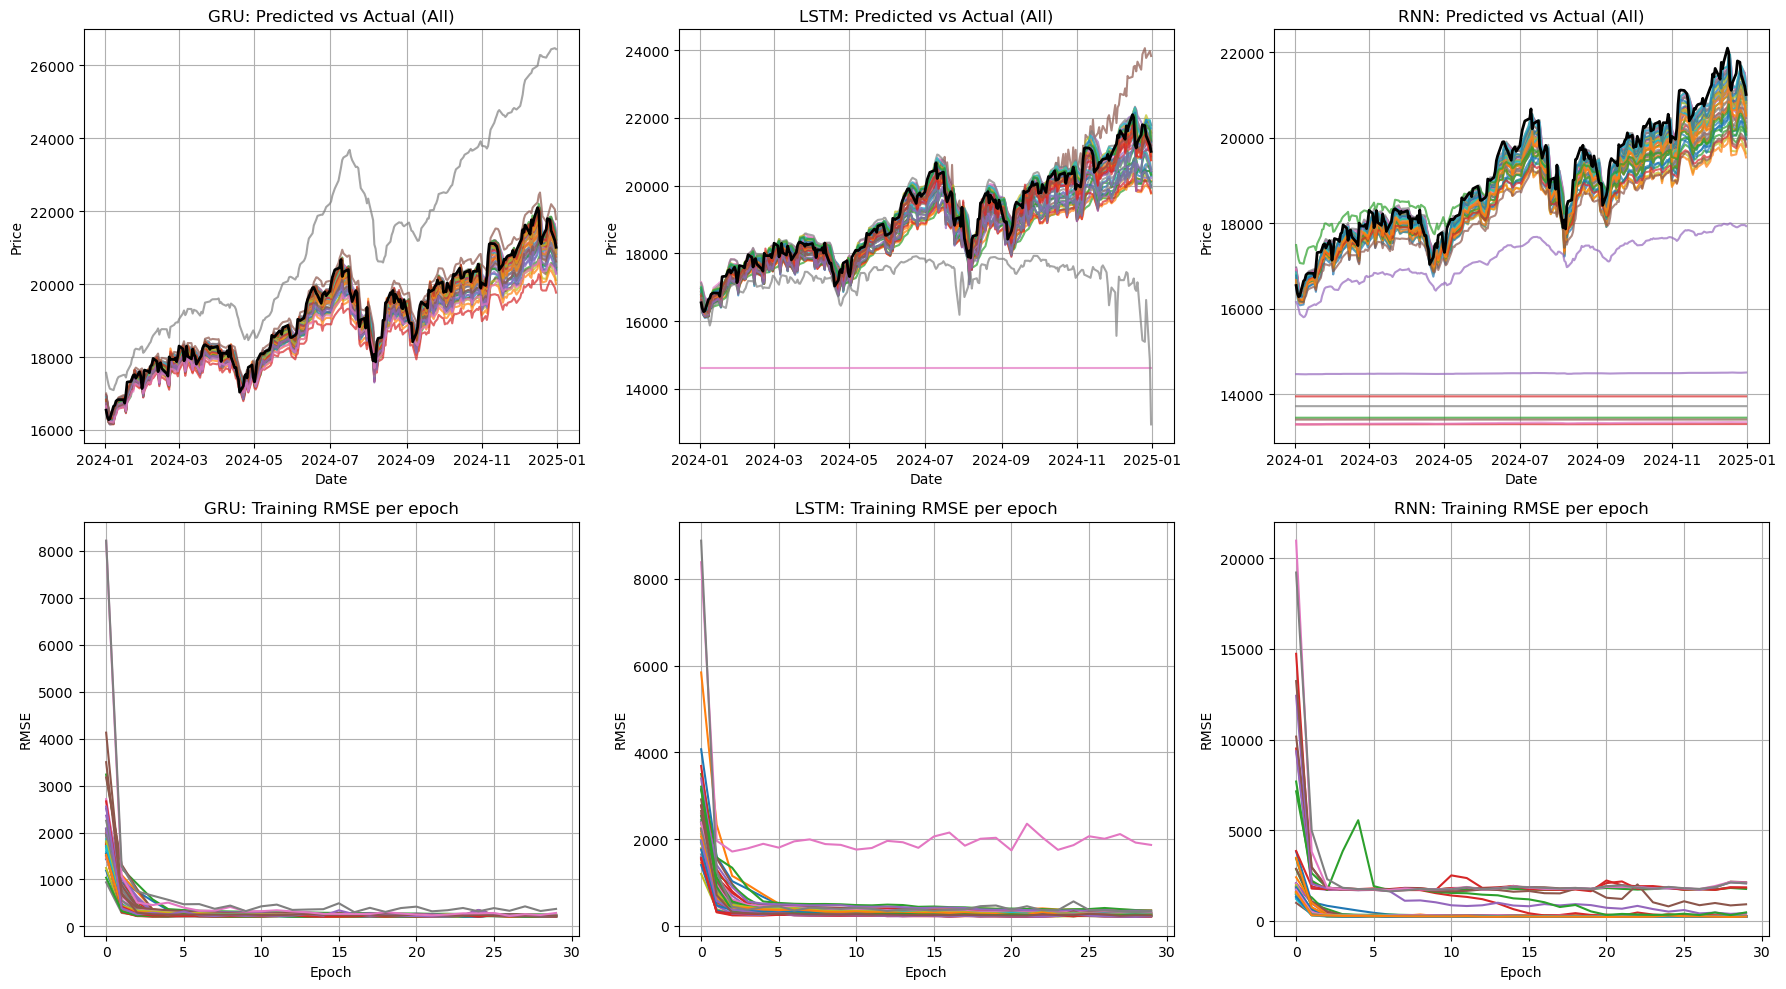

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx, (name, model_results) in enumerate(results.items()):
    ax1 = axs[0, idx]
    ax2 = axs[1, idx]

    for label, res in model_results.items():
        parts = label.split("_")
        H = parts[0][1:]
        LR = parts[1][2:]
        L = parts[2][1:]
        rmse = res["train_rmse"][-1]
        
        #previously I had a legend with labels for each set of hyperparameters but this became too cluttered 
        #the next set of plots pick out the best set of hyperparameters and display them
        #legend_label = f"H: {H}, LR: {LR}, L: {L}, RMSE={rmse:.4f}"

        ax1.plot(dates[test_idx].values, res["pred"], alpha=0.7)
        ax2.plot(res["train_rmse"])    

    #predictions
    ax1.plot(dates[test_idx].values, res["actual"], label="Actual", color="black", linewidth=2)
    ax1.set_title(f"{name}: Predicted vs Actual (All)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True)
    #ax1.legend(fontsize='small')

    #training loss
    ax2.set_title(f"{name}: Training RMSE per epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("RMSE")
    ax2.grid(True)
    #ax2.legend(fontsize='small')

plt.tight_layout()
plt.show()

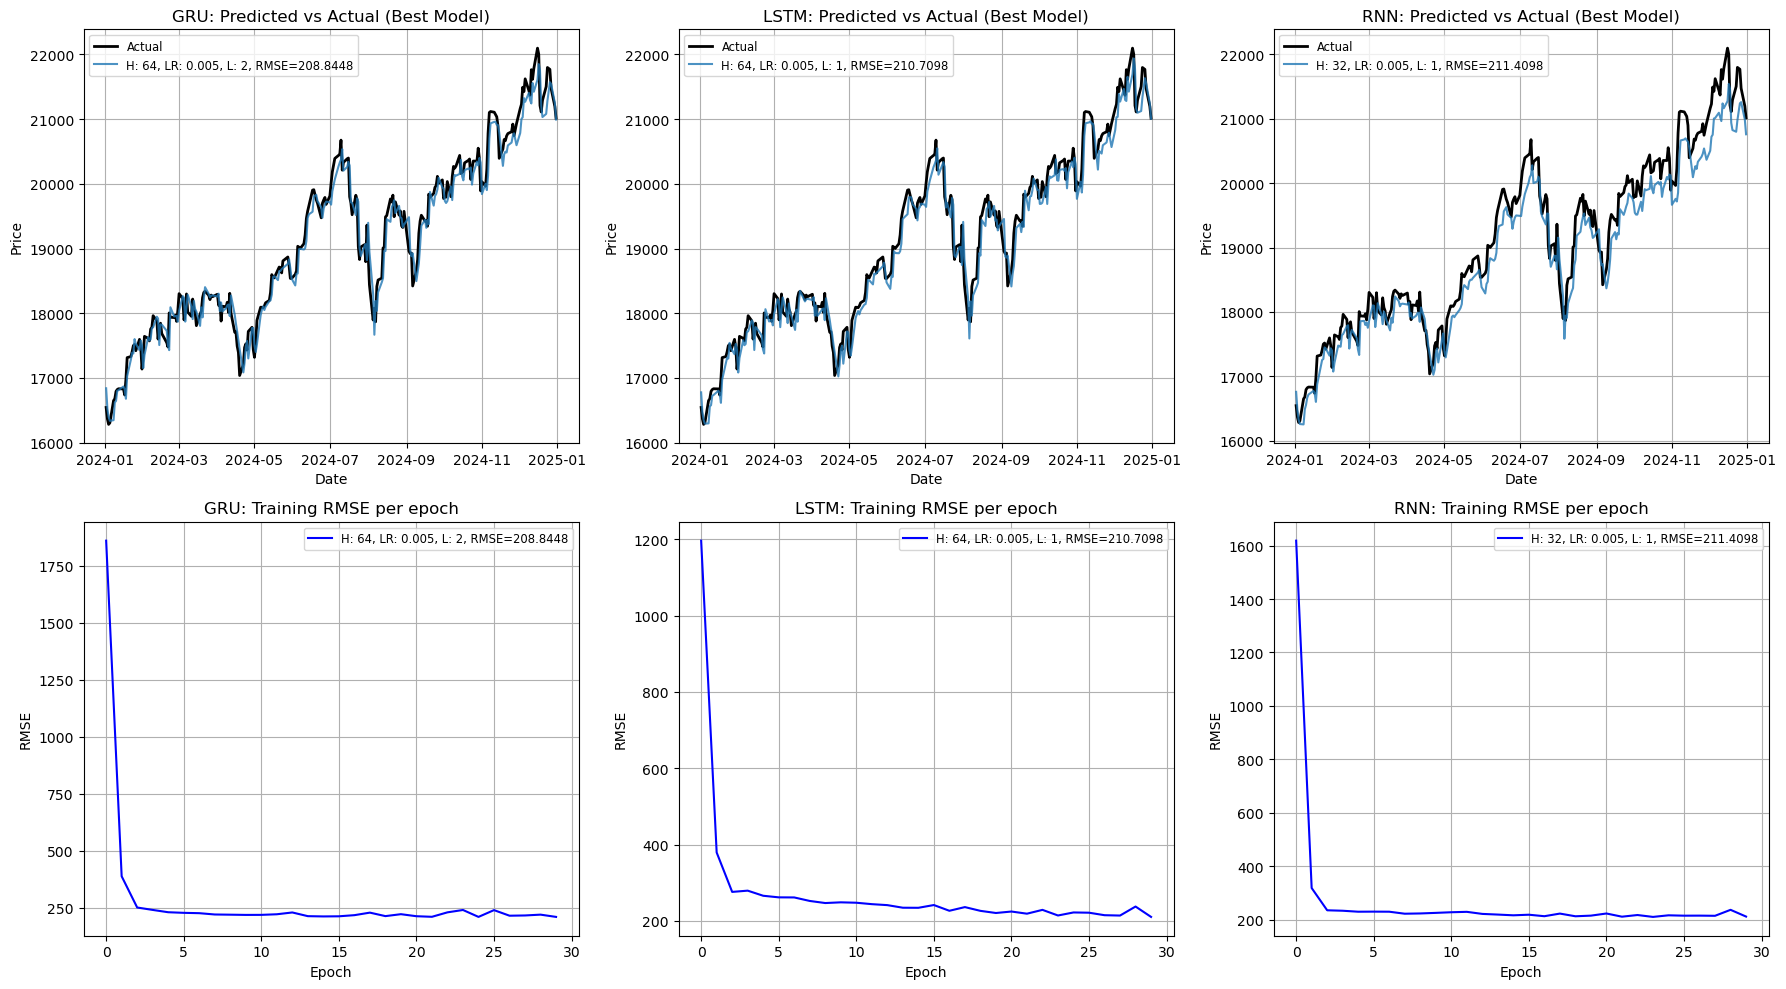

In [7]:
#pick and plot best model
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

best_configs = {}

for idx, (name, model_results) in enumerate(results.items()):
    ax1 = axs[0, idx]
    ax2 = axs[1, idx]

    #best model based on RMSE
    best_label, best_rmse = None, float("inf")
    for label, res in model_results.items():
        rmse = res["train_rmse"][-1]
        if rmse < best_rmse:
            best_label = label
            best_rmse = rmse

    best_res = model_results[best_label]
    parts = best_label.split("_")
    H = parts[0][1:]
    LR = parts[1][2:]
    L = parts[2][1:]
    legend_label = f"H: {H}, LR: {LR}, L: {L}, RMSE={best_rmse:.4f}"

    best_configs[name] = {
        "ModelClass": {"GRU": StockGRU, "LSTM": StockLSTM, "RNN": StockRNN}[name],
        "hidden_size": int(H),
        "learning_rate": float(LR),
        "num_layers": int(L)
    }

    ax1.plot(dates[test_idx].values, best_res["actual"], label="Actual", color="black", linewidth=2)
    ax1.plot(dates[test_idx].values, best_res["pred"], label=legend_label, alpha=0.8)
    ax1.set_title(f"{name}: Predicted vs Actual (Best Model)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True)
    ax1.legend(fontsize='small')

    ax2.plot(best_res["train_rmse"], label=legend_label, color="blue")
    ax2.set_title(f"{name}: Training RMSE per epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("RMSE")
    ax2.grid(True)
    ax2.legend(fontsize='small')

plt.tight_layout()
plt.show()

In [8]:
#validation, including 2024 now, re-prepping data

#refit scaler
scaler = MinMaxScaler()
scaled_full = scaler.fit_transform(df[features])

X_all, y_all = create_sequences(scaled_full, SEQ_LEN)
dates_all = df["Date"][SEQ_LEN:].reset_index(drop=True)

#2025 for validation
trainval_idx = dates_all.dt.year <= 2024
val2025_idx = dates_all.dt.year == 2025

X_trainval = X_all[trainval_idx]
y_trainval = y_all[trainval_idx]
X_val2025 = X_all[val2025_idx]
y_val2025 = y_all[val2025_idx]

X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32).to(device)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val2025, dtype=torch.float32).to(device)

In [9]:
#retrain each best model config and validate on 2025
for name, conf in best_configs.items():
    
    model = conf["ModelClass"](input_size=4, hidden_size=conf["hidden_size"], num_layers=conf["num_layers"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=conf["learning_rate"])
    loss_fn = nn.MSELoss()
    gen=torch.Generator().manual_seed(12) 
    train_loader = DataLoader(TensorDataset(X_trainval_tensor, y_trainval_tensor), batch_size=BATCH_SIZE, shuffle=True, generator=gen)
    
    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        y_pred_2025 = model(X_val_tensor.to(device)).squeeze().cpu().numpy()
        y_actual_2025 = y_val2025

        y_pred_unscaled = scaler.inverse_transform(
            np.column_stack([y_pred_2025, np.zeros((len(y_pred_2025), 3))])
        )[:, 0]
        y_actual_unscaled = scaler.inverse_transform(
            np.column_stack([y_actual_2025, np.zeros((len(y_actual_2025), 3))])
        )[:, 0]

        val_rmse = root_mean_squared_error(y_actual_unscaled, y_pred_unscaled)
        
        results[name]["final_val_rmse_2025"] = val_rmse
        results[name]["pred_2025"] = y_pred_unscaled
        results[name]["actual_2025"] = y_actual_unscaled

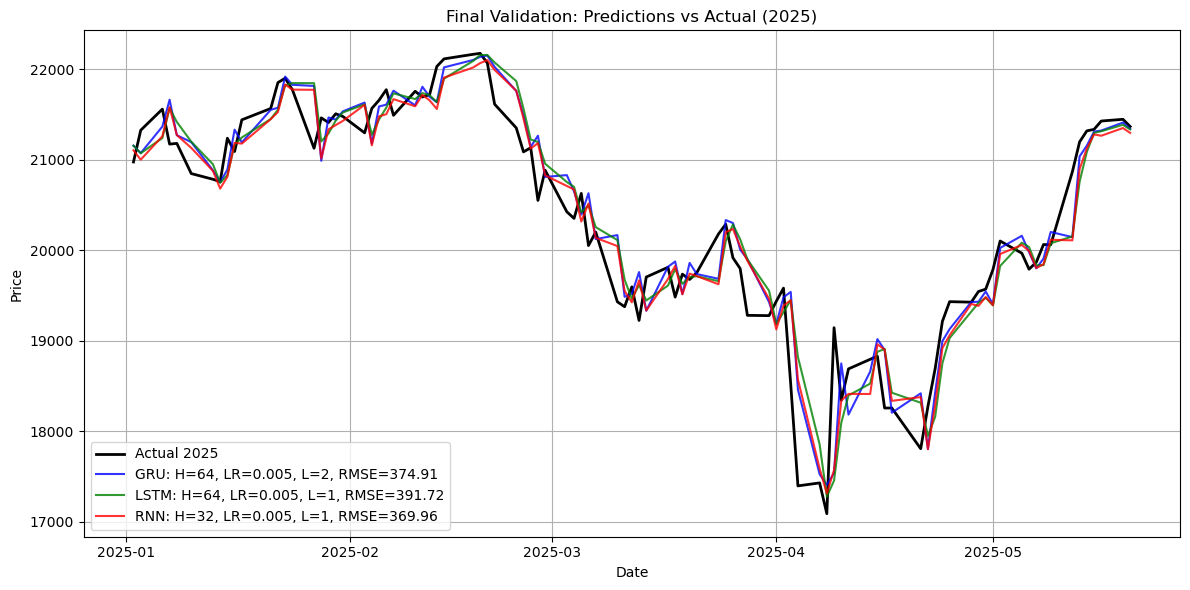

In [10]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(dates_all[val2025_idx], results["GRU"]["actual_2025"], label="Actual 2025", color="black", linewidth=2)

# Add model predictions with hyperparams in legend
for name, color in zip(["GRU", "LSTM", "RNN"], ["blue", "green", "red"]):
    conf = best_configs[name]
    rmse = results[name]["final_val_rmse_2025"]

    H = conf["hidden_size"]
    LR = conf["learning_rate"]
    L = conf["num_layers"]
    
    legend_label = f"{name}: H={H}, LR={LR}, L={L}, RMSE={rmse:.2f}"
    
    plt.plot(
        dates_all[val2025_idx],
        results[name]["pred_2025"],
        label=legend_label,
        color=color,
        alpha=0.8
    )

plt.title("Final Validation: Predictions vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()